In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

from Bio import SeqIO

In [2]:
%run settings/plt_settings.ipynb

In [7]:
PE_stats =  ! cat data/IN/uniprot/uniprot_sprot.dat  | grep ^PE  | sort | uniq -c
PE_stats

['  97542 PE   1: Evidence at protein level;',
 '  57085 PE   2: Evidence at transcript level;',
 ' 386028 PE   3: Inferred from homology;',
 '  13675 PE   4: Predicted;',
 '   1866 PE   5: Uncertain;']

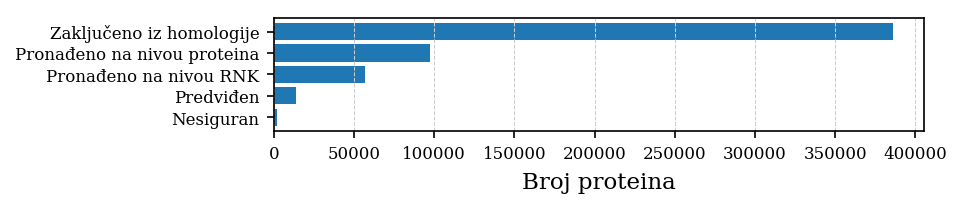

In [17]:
ns, labels = zip(*[ (pe[6:-1], int(n)) for n, pe in (l.split("PE") for l in PE_stats)])
ns = ['Pronađeno na nivou proteina','Pronađeno na nivou RNK','Zaključeno iz homologije','Predviđen','Nesiguran' ]

ns = [n for n in ns]
fig, ax = plt.subplots()
fig.set_figheight(1)
#fig.set_figwidth(4)

ax.barh(ns, labels)
ax.grid(which='major', axis='y')
ax.set_xlabel("Broj proteina")
#ax.set_title("Histogram nivoa pouzdanosti Svis-Prot proteina ")
plt.savefig('plots/PE.svg')

-----------

In [2]:
with open("./data/IN/valid_proteins.fasta") as handle:
    valid_cafa_seq = list( SeqIO.parse(handle, 'fasta') )
    valid_cafa_ac = {seq.id for seq in valid_cafa_seq}

ucitavamo swis prot, pokusavamo da nadjemo sve proteine 

In [3]:
with open("./data/IN/uniprot/uniprot_sprot.dat") as handle:
    swiss_seq = [ rec for rec in SeqIO.parse(handle, "swiss") if
                    any(ac in valid_cafa_ac for ac in rec.annotations["accessions"]) ]

swiss_seq_ac = {rec.id for rec in swiss_seq}
len(valid_cafa_ac), len(swiss_seq)

(66599, 66584)

In [5]:
missing_ac = valid_cafa_ac - swiss_seq_ac
len(missing_ac)

69

In [6]:
swiss_posible = [rec for rec in swiss_seq 
    if rec.id != valid_cafa_ac and any(ac in missing_ac for ac in rec.annotations["accessions"]) ]
len(swiss_posible)

69

In [7]:
acc_mapping = pd.DataFrame( [ (rec.id, ac) for rec in swiss_seq for ac in rec.annotations['accessions']
                                                                       if ac in missing_ac] 
                            , columns=['id', 'ac'])
print(len(set(acc_mapping.id)))
acc_mapping.head()

69


,id,ac
0,C0HK79,Q9D365
1,C0HK80,Q9D365
2,P0DP23,P62158
3,P0DP26,P62204
4,P0DP29,P62161


In [8]:
invalid_mid = set(acc_mapping.join(acc_mapping.groupby('ac').count(), on='ac', rsuffix='r').query("idr>1").id)
fixed_mapping = acc_mapping[ [mid not in invalid_mid for mid in acc_mapping.id]]

In [9]:
import pygraphviz as pgv
from IPython import display

In [10]:
G = pgv.AGraph(directed=True, size=10, strict=True, rankdir="BT")
for _, pac, sac in fixed_mapping.itertuples():
    G.add_node(pac, shape='rectangle')
    G.add_edge(sac, pac, len=1)
    

G.layout(prog='dot')
G.draw('plots/unifikacija_slogova.pdf', format='pdf')
display.display_svg(G.draw(format='svg'), raw=True)

In [11]:
for ac in set(fixed_mapping.id):
    print(ac, "Exists" if ac in valid_cafa_ac else "\\" )

P01597 \
P01706 Exists
P01619 \
P01701 Exists
P01715 Exists
P01700 Exists
P01721 Exists
P01814 \
P01624 Exists
P80748 Exists
P01871 Exists
P01743 Exists
P01593 Exists
P01704 Exists
P01599 Exists
P01742 Exists
P01709 Exists
Q64680 Exists
P01615 \


# razlike u sekvencama

In [12]:
final_swis_seq = [ rec for rec in swiss_seq if rec.id in valid_cafa_ac ]
final_ac_set = {rec.id for rec in final_swis_seq}
fianl_cafa = [rec for rec in valid_cafa_seq if rec.id in final_ac_set]

In [13]:
final_swis_seq =  sorted(final_swis_seq, key=lambda rec: rec.id)
fianl_cafa =  sorted(fianl_cafa, key=lambda rec: rec.id)
print(len(final_swis_seq) == len(final_swis_seq))
all(x.id == y.id for x,y in zip(final_swis_seq,  fianl_cafa))

True


True

In [14]:
ac2go =  { rec.id: {} for rec in final_swis_seq}
for ac, df in pd.read_csv('data/IN/CAFA3/uniprot_sprot_exp.txt', sep='\t', names=['ac', 'go', 'f']).groupby('ac'):
    if ac in ac2go:
        ac2go[ac] = set(df.go)

In [16]:
%run settings/db_connect.ipynb

In [17]:
go2namespace = sql("""
select id as go, namespace from go
""")
go2namespace.head()

,namespace
go,
GO:0000001,BP
GO:0000002,BP
GO:0000003,BP
GO:0000005,MF
GO:0000006,MF


In [18]:
cafa3_ac2go = pd.read_csv('data/IN/CAFA3/uniprot_sprot_exp.txt', sep='\t', names=['ac', 'go', 'f'])
cafa3_ac2go = cafa3_ac2go[cafa3_ac2go.ac.isin( {rec.id for rec in fianl_cafa} )]
cafa3_go_mf = cafa3_ac2go.query(" f=='F' ")[['go']].drop_duplicates().set_index('go')
cafa3_go_mf = cafa3_go_mf.join(go2namespace)
print("count cafa3_go_mf:", len(cafa3_go_mf))
print("count cafa3_go_mf replaced:", len( cafa3_go_mf.query(" namespace!='MF' ") ))

count cafa3_go_mf: 5957
count cafa3_go_mf replaced: 50


In [19]:
swis_ac2go = [ (rec.id, go[3:]) for
           rec in final_swis_seq for go  in rec.dbxrefs 
           if go.startswith("GO:") ]               
swis_ac2go = pd.DataFrame(swis_ac2go, columns=['ac', 'go'])

In [20]:
swis_ac2go = swis_ac2go.merge(go2namespace, left_on='go', right_index=True, how='left')
print("count swis_go_mf", len(swis_ac2go[swis_ac2go.namespace.isnull()])  )
print("count swis_go repalced:", len(swis_ac2go[swis_ac2go.namespace.isnull()])  )
swis_go_mf = swis_ac2go.query("namespace=='MF'")[['go', 'namespace']].drop_duplicates().set_index('go')


count swis_go_mf 319
count swis_go repalced: 319


In [21]:
go_mf_diff = cafa3_go_mf.merge(swis_go_mf, how='outer', left_index=True, right_index=True, suffixes=['_cafa3', '_swis'])

In [22]:
go_mf_diff.head()

,namespace_cafa3,namespace_swis
go,,
GO:0000006,MF,MF
GO:0000007,MF,MF
GO:0000009,MF,MF
GO:0000010,MF,MF
GO:0000014,MF,MF


In [23]:
sum(go_mf_diff.namespace_cafa3.isnull()),\
sum(go_mf_diff.namespace_swis.isnull())

(888, 67)

In [7]:
record = swiss_seq[1]

In [8]:
pprint(record.__dict__)

{'_per_letter_annotations': {},
 '_seq': Seq('MSTILEKISAIESEMARTQKNKATSAHLGLLKAKLAKLRRELISPKGGGGGTGE...KKV', ProteinAlphabet()),
 'annotations': {'accessions': ['P32234', 'Q9V648'],
                 'comment': 'FUNCTION: Deformed (Dfd) is required to activate '
                            '1.28up in maxillary segment cells. '
                            '{ECO:0000269|PubMed:8104141}.\n'
                            'TISSUE SPECIFICITY: Expressed in '
                            'posterior-lateral epidermis of the maxillary '
                            'lobe. {ECO:0000269|PubMed:8104141}.\n'
                            'DEVELOPMENTAL STAGE: Expressed in embryos and '
                            'adults. {ECO:0000269|PubMed:8104141}.\n'
                            'SIMILARITY: Belongs to the TRAFAC class '
                            'OBG-HflX-like GTPase superfamily. OBG GTPase '
                            'family. {ECO:0000255|PROSITE- ProRule:PRU01047}.',
                 'date': '01